In [1]:
from torch_geometric.data import Data
import torch
import torch.nn as nn
import torch.nn.functional as F 
import random
from torch_geometric.datasets import KarateClub
from utils import create_pointer_graph
import numpy as np

In [2]:
graph = KarateClub().data
graph.num_nodes = graph.num_nodes[0]
pg = create_pointer_graph(graph)

In [3]:
def random_walk(node, nsteps):
    s = set()
    s.add(node)
    for step in range(nsteps):
        new = np.random.choice(pg[node][0])
        s.add(new)
        node = new
    return s
random_walk(0, 3)

{0, 13, 19, 33}

In [34]:
def get_samples(node, nwalks, nsteps=4):
    l = []
    ii = -1
    for sample in range(nwalks):
        s = random_walk(node, nsteps)
        for pos_sample in s:
            l.append([node, pos_sample])
        for neg_sample in np.random.choice(list(range(graph.num_nodes)), len(s)):
            l[(ii:=ii+1)].append(neg_sample)
    return torch.tensor(l)
    return l

get_samples(0, 3)

tensor([[ 0,  0,  7],
        [ 0,  8,  6],
        [ 0, 32, 28],
        [ 0,  6, 13],
        [ 0,  0, 33],
        [ 0,  1, 27],
        [ 0,  2, 25],
        [ 0,  3, 16],
        [ 0, 13, 22],
        [ 0,  0, 26],
        [ 0, 33, 18],
        [ 0, 19, 14],
        [ 0, 21, 28]])

In [57]:
class Model(nn.Module):
    def __init__(self, emb_dim, num_nodes):
        super().__init__()
        self.emb_dim = emb_dim
        self.emb = nn.Embedding(num_nodes, emb_dim)
    def forward(self, x):
        return self.emb(x)
model = Model(2, graph.num_nodes)

In [60]:
opt = torch.optim.Adam(model.parameters(), lr=0.03)

In [80]:
for ep in range(1000):
    xanc, xpos, xneg = torch.zeros(0, 1).long(), torch.zeros(0, 1).long(), torch.zeros(0, 1).long()
    for node in range(graph.num_nodes):
        ret = get_samples(node, nwalks=2, nsteps=4).unsqueeze(-1)
        xanc, xpos, xneg = torch.cat((xanc, ret[:, 0])), torch.cat((xpos, ret[:, 1])), torch.cat((xneg, ret[:, 2]))

    loss = nn.TripletMarginLoss(2)(model(xanc), model(xpos), model(xneg))
    loss = loss.mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    if ep%20==0:
        print(ep, loss.item())

0 3.6593358516693115
20 4.090175628662109
40 4.114653587341309
60 3.0382673740386963
80 3.640909194946289
100 4.007525444030762
120 3.5709152221679688
140 3.085186004638672
160 4.03221321105957
180 3.700974941253662
200 3.629150390625
220 3.6256625652313232
240 3.6514153480529785
260 3.184277057647705
280 3.0821945667266846
300 3.086888313293457
320 3.036982297897339
340 2.9432485103607178
360 3.1501052379608154
380 3.1569972038269043
400 2.883939027786255
420 3.0397558212280273
440 3.3310115337371826
460 3.057448387145996
480 2.6119136810302734
500 2.6331679821014404
520 3.0943984985351562
540 2.542454957962036
560 2.507051706314087
580 2.8068385124206543
600 2.753164291381836
620 2.820094108581543
640 2.7678678035736084
660 2.8081531524658203
680 2.5441884994506836
700 1.8684123754501343
720 2.9588077068328857
740 2.5201528072357178
760 2.681326150894165
780 2.9165003299713135
800 2.925412654876709
820 2.763960123062134
840 2.0170726776123047
860 1.9726983308792114
880 2.049131393432

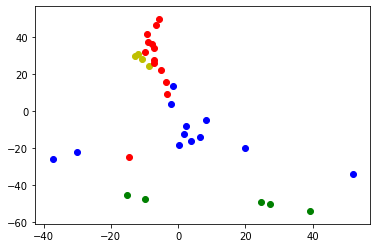

In [79]:
import matplotlib.pyplot as plt
colors = ['b' if y.item() else 'r' for y in graph.y]
colors = c2

for node in range(graph.num_nodes):
    emb = model(torch.tensor(node))
    x, y = [emb[0].item()], [emb[1].item()]
    plt.scatter(x, y, color=colors[node])
plt.show()f

In [73]:
idcs = torch.range(0, 33).long()
torch.cat((model.emb(idcs), 1+torch.range(0, 33).unsqueeze(-1)), dim=1)

tensor([[ 15.8428, -18.2163,   1.0000],
        [ 15.8358, -14.9149,   2.0000],
        [  6.7784,   1.4387,   3.0000],
        [ 15.8468, -14.9533,   4.0000],
        [-24.0517, -26.2026,   5.0000],
        [ 26.2079, -26.2222,   6.0000],
        [-24.0395, -26.2261,   7.0000],
        [ 15.8129, -14.8664,   8.0000],
        [ -1.4453,  11.5922,   9.0000],
        [  6.7192,  15.8245,  10.0000],
        [ 26.1470, -26.2289,  11.0000],
        [ 27.6832, -21.5974,  12.0000],
        [-28.1545, -18.1663,  13.0000],
        [ 15.7603, -14.4093,  14.0000],
        [-10.1417,  21.8674,  15.0000],
        [-10.1596,  28.1336,  16.0000],
        [ 26.2114, -26.2438,  17.0000],
        [-26.0400, -18.9786,  18.0000],
        [-10.2165,  27.6473,  19.0000],
        [ 18.4854, -13.8639,  20.0000],
        [-20.5337, -27.9761,  21.0000],
        [ 23.3692, -18.2200,  22.0000],
        [-10.1773,  25.4437,  23.0000],
        [-14.6261,  20.3671,  24.0000],
        [-15.2411,  20.3488,  25.0000],


In [55]:
colors2 = [2, 2, 2, 2, 3, 3, 3, 2, 1, 2, 3, 2, 2, 2, 1, 1, 3, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]
n2c = ['y', 'r', 'b', 'g']
c2 = [n2c[c] for c in colors2]
c2

['b',
 'b',
 'b',
 'b',
 'g',
 'g',
 'g',
 'b',
 'r',
 'b',
 'g',
 'b',
 'b',
 'b',
 'r',
 'r',
 'g',
 'b',
 'r',
 'b',
 'r',
 'b',
 'r',
 'r',
 'y',
 'y',
 'r',
 'y',
 'r',
 'r',
 'r',
 'y',
 'r',
 'r']

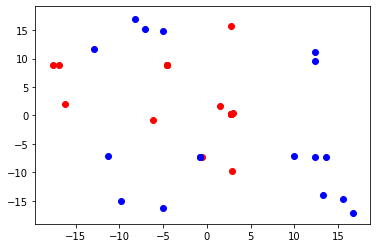

In [48]:
import matplotlib.pyplot as plt
colors = ['b' if y.item() else 'r' for y in graph.y]
for node in range(graph.num_nodes):
    emb = model(torch.tensor(node))
    x, y = [emb[0].item()], [emb[1].item()]
    plt.scatter(x, y, color=colors[node])
plt.show()

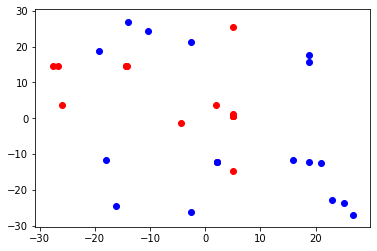

In [52]:
import matplotlib.pyplot as plt
colors = ['b' if y.item() else 'r' for y in graph.y]
for node in range(graph.num_nodes):
    emb = model(torch.tensor(node))
    x, y = [emb[0].item()], [emb[1].item()]
    plt.scatter(x, y, color=colors[node])
plt.show()